In [ ]:
!pip install peartree
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 4.2 MB/s eta 0:00:00


In [3]:
from datetime import datetime
import os
import requests
import tempfile

import geopandas as gpd
import pandas as pd
import networkx as nx
#import osmnx as ox
import numpy as np
#import peartree as pt
from shapely.geometry import Point
import datetime
from zipfile import ZipFile
import matplotlib.pyplot as plt

In [4]:
folder_name = "gtfs_subway"
with ZipFile(f"../Data/{folder_name}.zip") as myzip:
  shapes_df = pd.read_csv(myzip.open(f"{folder_name}/shapes.txt"), dtype={
          'shape_id': 'str',
          'shape_pt_lat': 'float',
          'shape_pt_lon': 'float',
          'shape_pt_sequence': 'Int64',
          'shape_dist_traveled': 'float',
      })

display(shapes_df)

,shape_id,shape_pt_sequence,shape_pt_lat,shape_pt_lon
0,1..N03R,0,40.702068,-74.013664
1,1..N03R,1,40.703199,-74.014792
2,1..N03R,2,40.703226,-74.014820
3,1..N03R,3,40.703253,-74.014846
4,1..N03R,4,40.703280,-74.014870
...,...,...,...,...
176477,SI.S31R,685,40.513696,-74.250493
176478,SI.S31R,686,40.513579,-74.250706
176479,SI.S31R,687,40.513458,-74.250917
176480,SI.S31R,688,40.513334,-74.251124


In [5]:
with ZipFile(f"../Data/{folder_name}.zip") as myzip:
    routes_df = pd.read_csv(myzip.open(f"{folder_name}/routes.txt"), dtype={
          'route_id': 'str',
          'agency_id': 'str',
          'route_short_name': 'str',
          'route_long_name': 'str',
          'route_desc': 'str',
          'route_type': 'Int64',
          'route_color': 'str',
          'route_text_color': 'str',
          'exact_times': 'bool'
      })

    trips_df = pd.read_csv(myzip.open(f"{folder_name}/trips.txt"), dtype={
        'route_id': 'str',
        'service_id': 'str',
        'trip_id': 'str',
        'shape_id': 'str',
        'trip_headsign': 'str',
        'direction_id': 'str',
        'block_id': 'str',
        'wheelchair_accessible': 'str',
        'route_direction': 'str',
        'trip_note': 'str',
        'bikes_allowed': 'str'
    })

    calendar_df = pd.read_csv(myzip.open(f"{folder_name}/calendar.txt"), dtype={
        'service_id': 'str',
        'monday': 'bool',
        'tuesday': 'bool',
        'wednesday': 'bool',
        'thursday': 'bool',
        'friday': 'bool',
        'saturday': 'bool',
        'sunday': 'bool',
        'start_date': 'str',
        'end_date': 'str',
    })

    calendar_dates_df = pd.read_csv(myzip.open(f"{folder_name}/calendar_dates.txt"), dtype={
        'service_id': 'str',
        'date': 'str',
        'exception_type': 'Int64',
    })

    stops_df = pd.read_csv(myzip.open(f"{folder_name}/stops.txt"), dtype={
        'stop_id': 'str',
        'stop_code': 'str',
        'stop_name': 'str',
        'stop_desc': 'str',
        'stop_lat': 'float',
        'stop_lon': 'float',
        'zone_id': 'str',
        'stop_url': 'str',
        'location_type': 'Int64',
        'parent_station': 'str',
        'stop_timezone': 'str',
        'wheelchair_boarding': 'str',
        'directionality': 'str',
        'platform_code': 'str'
    })

    stop_times_df = pd.read_csv(myzip.open(f"{folder_name}/stop_times.txt"), dtype={
        'trip_id': 'str',
        'arrival_time': 'str',
        'departure_time': 'str',
        'stop_id': 'str',
        'stop_sequence': 'Int64',
        'stop_headsign': 'str',
        'pickup_type': 'Int64',
        'drop_off_type': 'Int64',
        'shape_dist_traveled': 'float',
        'timepoint': 'Int64'
    })



In [6]:
stops_df['parent_stop_id'] = stops_df['stop_id'].str.replace('[NESW]$', '', regex=True)
stop_times_df['parent_stop_id'] = stop_times_df['stop_id'].str.replace('[NESW]$', '', regex=True)

# Check the columns
print(stops_df.columns)

# Check the first few rows to see the new column and its values
print(stops_df[['stop_id', 'parent_stop_id']].head())

Index(['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'location_type',
       'parent_station', 'parent_stop_id'],
      dtype='object')
  stop_id parent_stop_id
0     101            101
1    101N            101
2    101S            101
3     103            103
4    103N            103


In [7]:
# use trips and stops

G_directed = nx.DiGraph()

# Add nodes (stops) using the unique parent_stop_id
stop_nodes = stops_df[['parent_stop_id', 'stop_lat', 'stop_lon']].drop_duplicates()

# Create a dictionary of attributes for the nodes (stop coordinates)
node_attrs = stop_nodes.set_index('parent_stop_id').to_dict('index')

# Add nodes to the graph with attributes
G_directed.add_nodes_from(node_attrs.keys())
nx.set_node_attributes(G_directed, node_attrs)

print(f"Nodes added: {G_directed.number_of_nodes()}")

Nodes added: 499


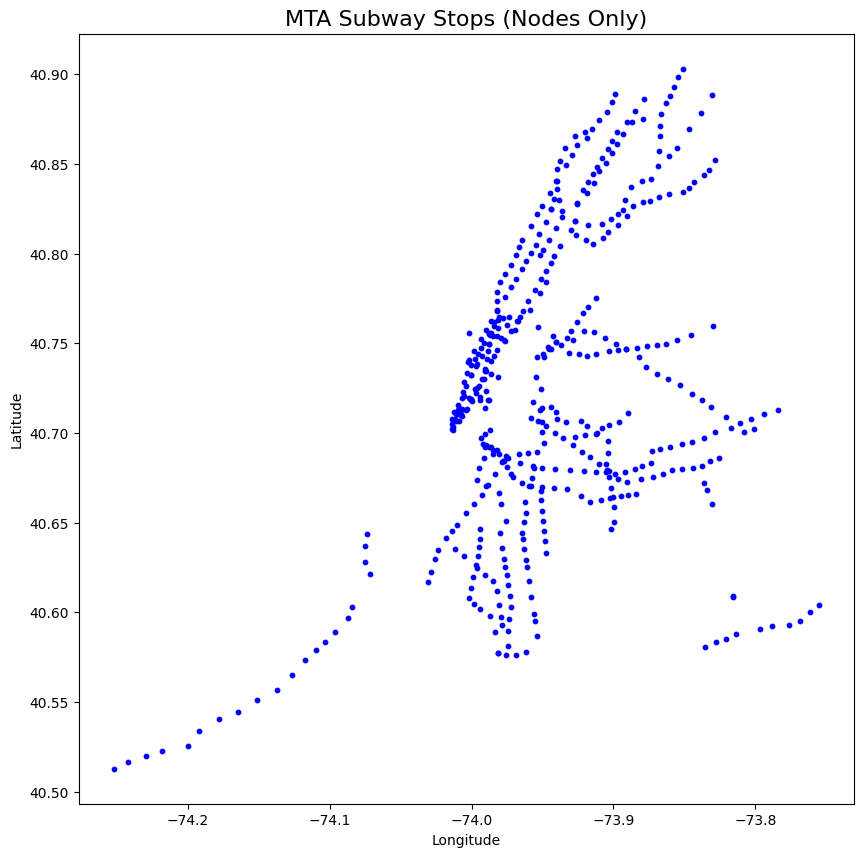

In [8]:
pos = {
    node: (data['stop_lon'], data['stop_lat'])
    for node, data in node_attrs.items()
}

fig, ax = plt.subplots(figsize=(10, 10))

nx.draw_networkx_nodes(
    G_directed,
    pos, # Use the extracted longitude and latitude
    node_size=10, # Adjust size for visibility
    node_color='blue',
    ax=ax
)

ax.set_title("MTA Subway Stops (Nodes Only)", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [9]:
# display(stop_times_df)
# print()
# display(trips_df)
# print()

# Merge stop_times with trips to get route_id and other trip info
st_trips_df = stop_times_df.merge(
    trips_df[['trip_id', 'route_id', 'direction_id']],
    on='trip_id',
    how='left'
)

# Sort the stops for each trip based on the stop_sequence
st_trips_df = st_trips_df.sort_values(['trip_id', 'stop_sequence'])

# Convert the parent_stop_id column for consistency and ease of use
st_trips_df['parent_stop_id'] = st_trips_df['stop_id'].str.replace('[NESW]$', '', regex=True)

display(st_trips_df)

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,parent_stop_id,route_id,direction_id
0,ASP25GEN-1038-Sunday-00_000600_1..S03R,101S,00:06:00,00:06:00,1,101,1,1
1,ASP25GEN-1038-Sunday-00_000600_1..S03R,103S,00:07:30,00:07:30,2,103,1,1
2,ASP25GEN-1038-Sunday-00_000600_1..S03R,104S,00:09:00,00:09:00,3,104,1,1
3,ASP25GEN-1038-Sunday-00_000600_1..S03R,106S,00:10:30,00:10:30,4,106,1,1
4,ASP25GEN-1038-Sunday-00_000600_1..S03R,107S,00:12:00,00:12:00,5,107,1,1
...,...,...,...,...,...,...,...,...
562078,SIR-FA2017-SI017-Weekday-08_147100_SI..N03R,S27N,25:03:00,25:03:00,17,S27,SI,0
562079,SIR-FA2017-SI017-Weekday-08_147100_SI..N03R,S28N,25:06:00,25:06:00,18,S28,SI,0
562080,SIR-FA2017-SI017-Weekday-08_147100_SI..N03R,S29N,25:08:00,25:08:00,19,S29,SI,0
562081,SIR-FA2017-SI017-Weekday-08_147100_SI..N03R,S30N,25:10:00,25:10:00,20,S30,SI,0


In [10]:
# Identify the next stop for each stop in a trip
st_trips_df['next_stop_id'] = st_trips_df.groupby('trip_id')['parent_stop_id'].shift(-1)

# Filter out the last stop of each trip (where next_stop_id is NaN)
edges_df = st_trips_df.dropna(subset=['next_stop_id']).copy()

# Rename columns for clarity (source and target)
edges_df = edges_df.rename(columns={'parent_stop_id': 'source', 'next_stop_id': 'target'})

# Select and process relevant columns for edges
edges_for_graph = edges_df[['source', 'target', 'trip_id', 'route_id', 'direction_id', 'stop_sequence', 'arrival_time', 'departure_time']].copy()

# Remove duplicate edges (i.e., multiple trips using the exact same stop-to-stop segment)
# For simplicity, we'll keep one representation of the directed edge, but note that a full
# temporal graph would need to consider all trips/times. For a basic topology, we de-duplicate.
unique_edges = edges_for_graph[['source', 'target', 'route_id', 'direction_id']].drop_duplicates()

print(f"Unique directed edges (segments) found: {len(unique_edges)}")

Unique directed edges (segments) found: 2065


In [11]:
# Add edges to the directed graph G_directed
# Include route_id and direction_id as edge attributes
G_directed.add_edges_from(
    unique_edges[['source', 'target']].values,
)

# Add edges to the directed graph G_directed
for _, row in unique_edges.iterrows():
    source = row['source']
    target = row['target']
    route_id = row['route_id']
    direction_id = row['direction_id']

    # Use G_directed.add_edge with the attribute. If the edge already exists,
    # this will update its attributes, but we need to check the existing data first.
    edge_data = G_directed.get_edge_data(source, target)

    if edge_data is None:
        # Edge does not exist: add it with new lists for route_ids and directions
        G_directed.add_edge(
            source, target,
            route_ids=[route_id],
            directions=[direction_id]
        )
    else:
        # Edge exists: Ensure attributes are lists and append if route_id is new

        # Initialize 'route_ids' if it's missing or not a list
        if 'route_ids' not in edge_data or not isinstance(edge_data['route_ids'], list):
            edge_data['route_ids'] = []

        # Initialize 'directions' if it's missing or not a list
        if 'directions' not in edge_data or not isinstance(edge_data['directions'], list):
            edge_data['directions'] = []

        # Now we can safely check and append
        if route_id not in edge_data['route_ids']:
            edge_data['route_ids'].append(route_id)

        if direction_id not in edge_data['directions']:
            edge_data['directions'].append(direction_id)

In [12]:
print(f"Total Nodes: {G_directed.number_of_nodes()}")
print(f"Total Edges (Segments) added: {G_directed.number_of_edges()}")

Total Nodes: 499
Total Edges (Segments) added: 1139


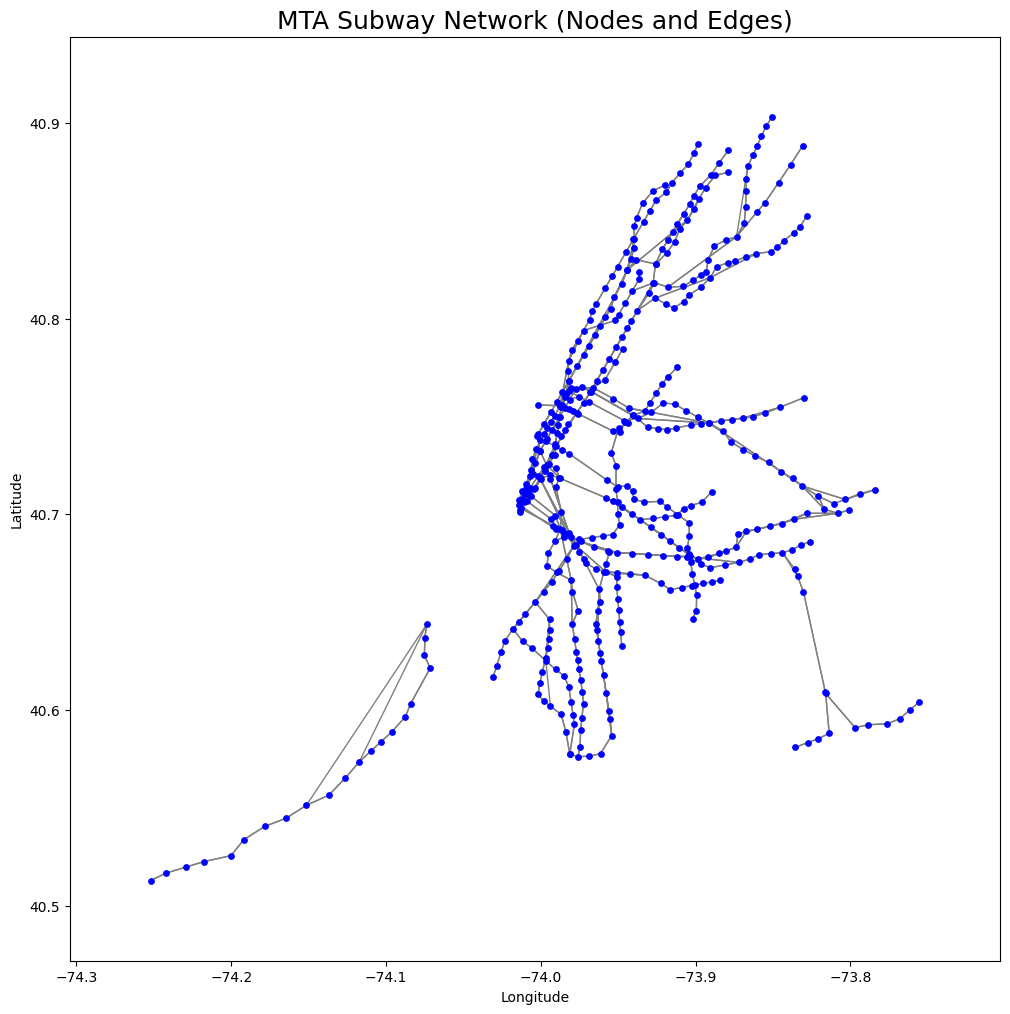

In [13]:
fig, ax = plt.subplots(figsize=(12, 12))

# Draw Edges first
nx.draw_networkx_edges(
    G_directed,
    pos,
    edge_color='gray',
    alpha=1,
    width=1,
    arrows=False,
    ax=ax
)

# Draw Nodes on top
nx.draw_networkx_nodes(
    G_directed,
    pos,
    node_size=15,
    node_color='blue',
    ax=ax
)

ax.set_title("MTA Subway Network (Nodes and Edges)", fontsize=18)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

# Linear Scale Degree Plot

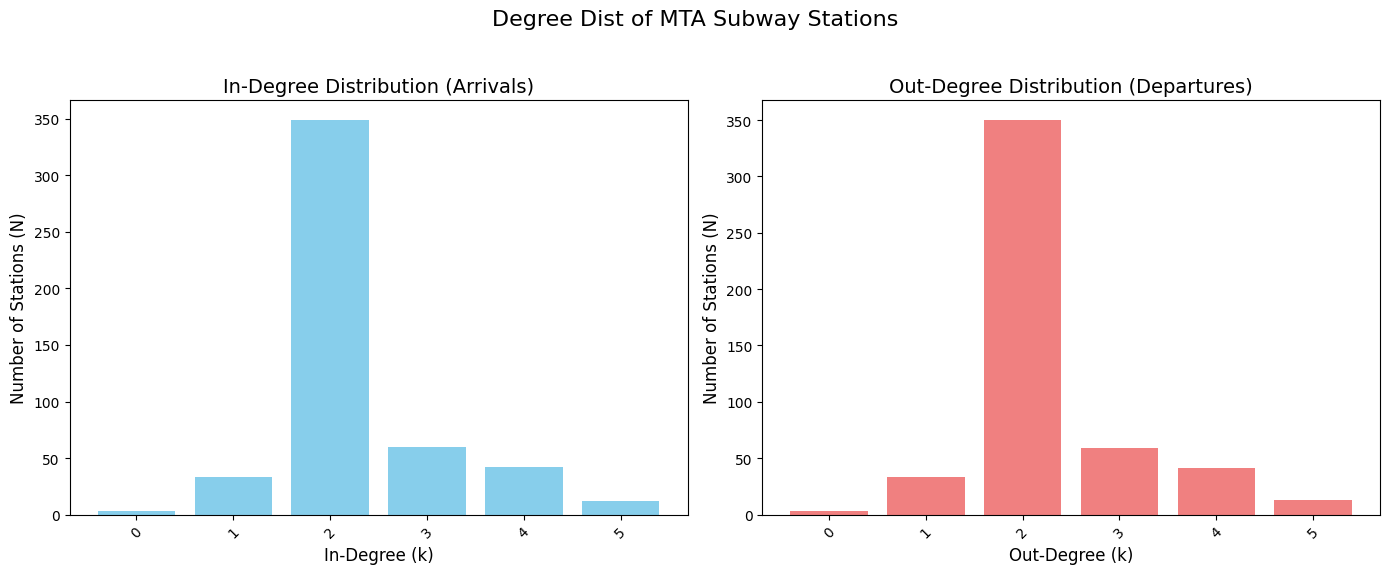

In [ ]:
from collections import Counter

# Calculate in-degree for all nodes
in_degree_sequence = sorted([d for n, d in G_directed.in_degree()], reverse=True)
in_degree_counts = Counter(in_degree_sequence)
in_deg, in_cnt = zip(*in_degree_counts.items())

# Calculate outdegree for all nodes
out_degree_sequence = sorted([d for n, d in G_directed.out_degree()], reverse=True)
out_degree_counts = Counter(out_degree_sequence)
out_deg, out_cnt = zip(*out_degree_counts.items())

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Degree Dist of MTA Subway Stations", fontsize=16)

# Plot In-Degree Distribution
ax[0].bar(in_deg, in_cnt, width=0.8, color='skyblue')
ax[0].set_title("In-Degree Distribution (Arrivals)", fontsize=14)
ax[0].set_xlabel("In-Degree (k)", fontsize=12)
ax[0].set_ylabel("Number of Stations (N)", fontsize=12)
ax[0].set_xticks(in_deg)
ax[0].tick_params(axis='x', rotation=45)

# Plot Out-Degree Distribution
ax[1].bar(out_deg, out_cnt, width=0.8, color='lightcoral')
ax[1].set_title("Out-Degree Distribution (Departures)", fontsize=14)
ax[1].set_xlabel("Out-Degree (k)", fontsize=12)
ax[1].set_ylabel("Number of Stations (N)", fontsize=12)
ax[1].set_xticks(out_deg)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Assuming G_directed is your NetworkX graph

# Get the degrees for all nodes as dictionaries {node_id: degree}
all_in_degrees = dict(G_directed.in_degree())
all_out_degrees = dict(G_directed.out_degree())

## A. Count Stations with In-Degree 0
# These are stops that trains never arrive at (highly unusual, may be an isolated stop or a start node)
in_degree_zero_count = sum(1 for degree in all_in_degrees.values() if degree == 0)

## B. Count Stations with Out-Degree 0
# These are stops that trains never depart from (highly unusual, may be an isolated stop or an end node)
out_degree_zero_count = sum(1 for degree in all_out_degrees.values() if degree == 0)

## C. Find the Isolated Stations (In-Degree 0 AND Out-Degree 0)
# These stations have no connections whatsoever.
isolated_nodes = [node for node, degree in all_in_degrees.items() if degree == 0 and all_out_degrees[node] == 0]
isolated_count = len(isolated_nodes)



print(f"Total Stations: {G_directed.number_of_nodes()}")
print(f"Stations with In-Degree 0: {in_degree_zero_count}")
print(f"Stations with Out-Degree 0: {out_degree_zero_count}")
print(f"Total Isolated Stations: {isolated_count}")

Total Stations: 499
Stations with In-Degree 0: 3
Stations with Out-Degree 0: 3
Total Isolated Stations: 3


# Logarithmic scale degree plot

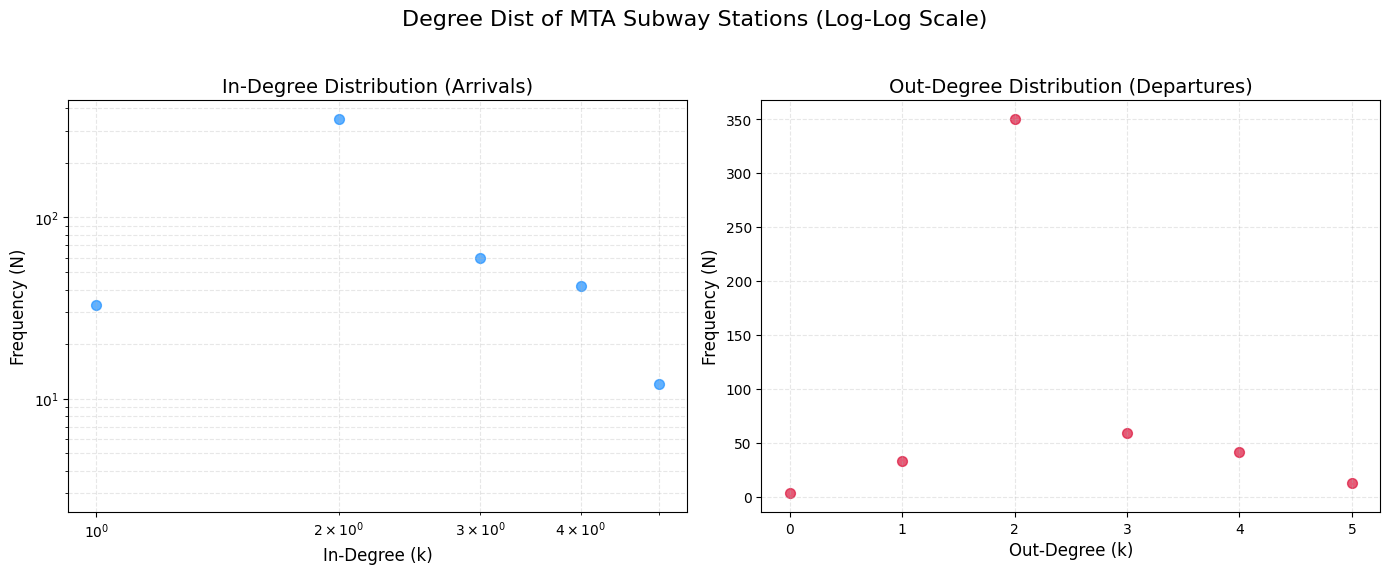

In [ ]:
from collections import Counter

# Calculate in-degree for all nodes
in_degree_sequence = sorted([d for n, d in G_directed.in_degree() if d >= 0], reverse=True)
in_degree_counts = Counter(in_degree_sequence)
in_deg, in_cnt = zip(*in_degree_counts.items())

# Calculate outdegree for all nodes
out_degree_sequence = sorted([d for n, d in G_directed.out_degree() if d >= 0], reverse=True)
out_degree_counts = Counter(out_degree_sequence)
out_deg, out_cnt = zip(*out_degree_counts.items())

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Degree Dist of MTA Subway Stations (Log-Log Scale)", fontsize=16)

# Plot In-Degree Distribution
ax[0].scatter(in_deg, in_cnt, color='dodgerblue', alpha=0.7, s=50)
ax[0].set_title("In-Degree Distribution (Arrivals)", fontsize=14)
ax[0].set_xlabel("In-Degree (k)", fontsize=12)
ax[0].set_ylabel("Frequency (N)", fontsize=12)
ax[0].set_xscale('log') # Set X to log scale
ax[0].set_yscale('log') # Set Y to log scale
ax[0].grid(True, which="both", ls="--", alpha=0.3) # Add grid for better readability

# Plot Out-Degree Distribution
ax[1].scatter(out_deg, out_cnt, color='crimson', alpha=0.7, s=50)
ax[1].set_title("Out-Degree Distribution (Departures)", fontsize=14)
ax[1].set_xlabel("Out-Degree (k)", fontsize=12)
ax[1].set_ylabel("Frequency (N)", fontsize=12)
ax[1].grid(True, which="both", ls="--", alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

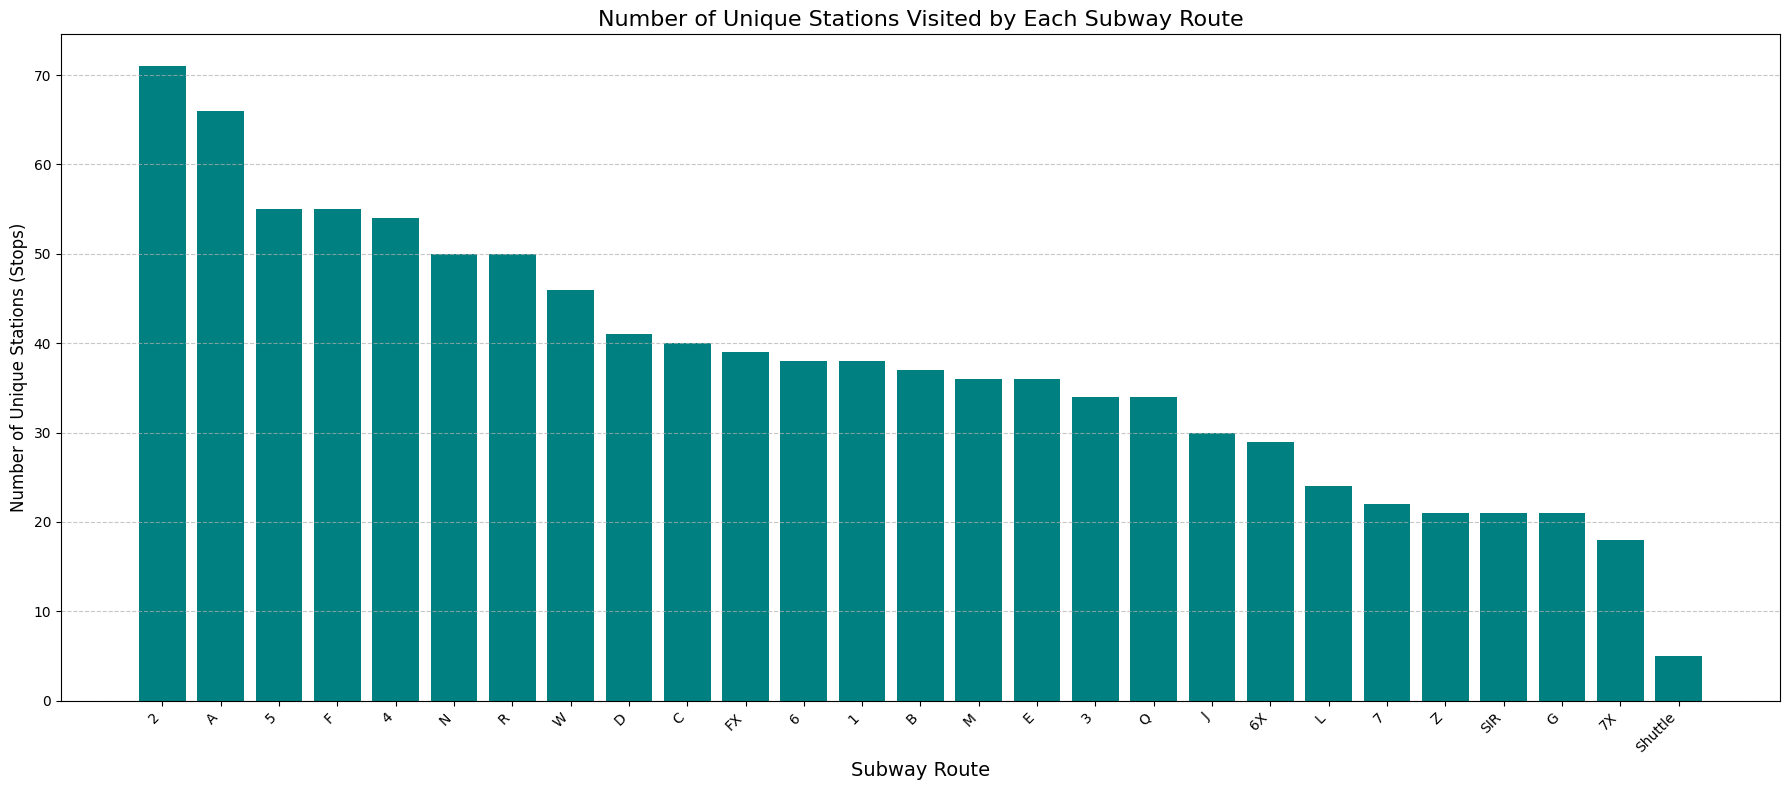

In [15]:
## SETTING UP

# Count the number of unique stops per route_id
# We use edges_for_graph or st_trips_df as it contains route_id and stops
route_stops_count = edges_for_graph.groupby('route_id')['source'].nunique().reset_index(name='num_stations')

# Merge with the routes_df to get the route names/identifiers
route_stops_count = route_stops_count.merge(
    routes_df[['route_id', 'route_short_name', 'route_long_name']],
    on='route_id',
    how='left'
).sort_values(by='num_stations', ascending=False)

# Create the final route label
route_stops_count['route_label'] = route_stops_count['route_short_name'].fillna(route_stops_count['route_id'])

# Define category logic: 1=Numbered, 2=Lettered, 3=Special
def get_route_category(label):
    if label in ['SIR', 'TX', 'GX', 'S']:
        return 3  # Special services
    if label.isdigit():
        return 1  # Numbered routes
    return 2  # Lettered routes

# Apply the sorting category
route_stops_count['sort_category'] = route_stops_count['route_label'].apply(get_route_category)

# What even is S lol? Update it
route_stops_count.loc[route_stops_count['route_label'] == 'S', 'route_label'] = 'Shuttle'

# Sort by category (1, 2, 3), then by number of stations (descending), then alphabetically (ascending)
route_stops_count_sorted = route_stops_count.sort_values(
    by=['sort_category', 'num_stations', 'route_label'],
    ascending=[True, False, True]
)

## PLOTTING

# Create the plot
plt.figure(figsize=(18, 8))

# Plot the bar chart
plt.bar(
    route_stops_count['route_label'],
    route_stops_count['num_stations'],
    color='teal'
)

plt.title("Number of Unique Stations Visited by Each Subway Route", fontsize=16)
plt.xlabel("Subway Route", fontsize=14)
plt.ylabel("Number of Unique Stations (Stops)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(bottom=0)
plt.tight_layout()

plt.show()